# Basic Vision Transformer (ViT) Implementation

This notebook contains code (to be refactored into scripts at a later stage) that implements a basic ViT to be trained on MNIST, CIFAR10, and CIFAR100. 

The implementation is written using PyTorch and allows for the following options:

- Different datasets: MNIST, CIFAR10, and CIFAR100 (more to be added in future - please open an issue if you would like to see a specific dataset added)
- Image augmentation and resizing
- Different patch sizes
- Different number of layers
- Different number of heads
- Different number of channels
- Different number of classes
- Different number of epochs
- Different batch sizes
- Different learning rates
- Different optimizers
- Different weight decay
- Different dropout rates
- Different number of workers
- Different number of GPUs

The implementation is based on the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Dosovitskiy et al.

The purpose of this notebook is to provide a basic implementation of ViT that can be used as a starting point for more advanced implementations. The user has the flexibility to change the hyperparameters and the architecture to suit their needs by editing the configs. 

The code is optimised for readability and speed where possible.

In future the code will be refactored into scripts and the configs will be moved to a separate file, whereby the user can edit the configs in the file to suit their experimentations.

In [42]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time

# Machine learning imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor, optim
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Third-party imports
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image
from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [43]:
# Function that sets device to either Cuda (GPU), MPS (Apple Silicon GPU), or CPU
def set_device():
    # Set device: either Cuda (GPU), MPS (Apple Silicon GPU), or CPU
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    return device

In [44]:
def simple_transform():
    '''Return a simple transformation for validation/testing.'''
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform

In [45]:
def data_loader(dataset: str, batch_size: int, image_size: int, augment: bool = True):
    '''
    Function that takes in a dataset and returns train and test dataloaders along with the hyperparameters
    associated with the dataset.

    Parameters:
        dataset (str): Name of dataset to load. Options: MNIST, CIFAR10, CIFAR100
        batch_size (int): Batch size for dataloaders
        augment (bool): Whether to augment training data or not
        
    Returns:
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        test_loader (DataLoader): Dataloader for test set
        num_classes (int): Number of classes in dataset
        image_size (int): Size of image in dataset
        batch_size (int): Batch size for dataloaders
    '''

    base_train_transforms = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    if dataset == "MNIST":
        base_train_transforms.append(transforms.Normalize((0.5,), (0.5,)))
    elif dataset == "CIFAR10":
        mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
        base_train_transforms.append(transforms.Normalize(mean, std))
    elif dataset == "CIFAR100":
        mean, std = (0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
        base_train_transforms.append(transforms.Normalize(mean, std))

    # Additional augmentations for CIFAR10 and CIFAR100
    additional_transforms = []
    if augment:

        additional_transforms = [
            transforms.Resize((image_size, image_size)),
            # transforms.RandomCrop(image_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(3.6),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),

        ]
    
    dataset_config = {
        'MNIST': {
            'num_classes': 10,
            'default_image_size': 28,
            'batch_size': batch_size,  # Use the batch_size parameter
            'train_transform': transforms.Compose(base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        },
        'CIFAR10': {
            'num_classes': 10,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
            ])
        },
        'CIFAR100': {
            'num_classes': 100,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
            ])
        }
    }    

    # Ensure dataset is valid
    if dataset not in dataset_config:
        raise ValueError(f"Unsupported dataset: {dataset}. Supported datasets are: {', '.join(dataset_config.keys())}")

    # Access config
    cfg = dataset_config[dataset]

    # Print loading info
    print(f'Loading {dataset} dataset...')

    # Load data
    if dataset == 'MNIST':
        dataset_cls = datasets.MNIST
    elif dataset == 'CIFAR10':
        dataset_cls = datasets.CIFAR10
    else:
        dataset_cls = datasets.CIFAR100

    train_dataset_full = dataset_cls(f'../data/{dataset}_data/', train=True, download=True, transform=cfg['train_transform'])
    test_dataset = dataset_cls(f'../data/{dataset}_data/', train=False, download=True, transform=cfg['test_transform'])

    # Split training dataset into training and validation sets
    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    # Compute optimal number of workers
    num_workers = min(4, os.cpu_count())

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, cfg['num_classes'], cfg['default_image_size'], batch_size


In [46]:
class PatchEmbedding(nn.Module):
    '''
    Class that creates patch embeddings for images
    (image to patch embeddings).

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension

    Returns:
        x (Tensor): Patch embeddings
    '''
    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2

        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Converts an input image tensor into patch embeddings.

        Args:
            x (Tensor): Input image tensor of shape (B, C, H, W).

        Returns:
            Tensor: The patch embeddings of shape (B, num_patches, embed_dim).
        """
        x = self.projection(x).flatten(2).transpose(1, 2)

        return x

In [47]:
class Attention(nn.Module):
    '''
    Class that creates an attention layer.

    Parameters:
        dim (int): Dimension of input
        heads (int): Number of heads
        dim_head (int): Dimension of each head
        dropout (float): Dropout probability

    Returns:
        x (Tensor): Output of attention layer
    '''
    
    def __init__(self, 
                dim: int, 
                heads: int, 
                dim_head: int, 
                dropout: float=0.):
        super().__init__()
        
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        # Linear layer to get Q, K, V
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attend = nn.Softmax(dim=-1)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        
        # Obtain Q, K, V from input tensor x
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.dim_head).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores and apply scaling
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        
        # Softmax to get attention weights
        attn = self.attend(dots)
        
        # Calculate the output tensor
        out = torch.einsum('bhij,bhjd->bhid', attn, v).reshape(B, N, C)
        out = self.proj(out)
        return out


In [48]:
class MLP(nn.Module):
    '''
    Class that creates a multilayer perceptron (MLP).

    Parameters:
        in_features (int): Number of input features
        hidden_features (int, optional): Number of hidden features. Defaults to in_features.
        out_features (int, optional): Number of output features. Defaults to in_features.
        activation (nn.Module, optional): Activation function. Defaults to nn.GELU().
        drop (float, optional): Dropout probability. Defaults to 0.

    Returns:
        x (Tensor): Output of MLP
    '''
    def __init__(self, 
                 in_features: int, 
                 hidden_features: int = None, 
                 out_features: int = None, 
                 activation: nn.Module = nn.GELU(),
                 drop: float = 0.):
        super().__init__()
        
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


In [49]:
class TransformerEncoderBlock(nn.Module):
    '''
    Class that creates a transformer encoder block.

    Parameters:
        dim (int): Embedding dimension
        heads (int): Number of heads
        dim_head (int): Dimension of each head
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability

    Returns:
        x (Tensor): Output of transformer encoder block
    '''
    def __init__(self, 
                 dim: int, 
                 heads: int, 
                 dim_head: int, 
                 mlp_dim: int, 
                 dropout: float = 0.):
        super().__init__()
        
        # Layer normalization followed by attention (with residual)
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        
        # Layer normalization followed by feed-forward (with residual)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_dim, out_features=dim, drop=dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply attention, add residual connection, and apply dropout
        x = x + self.dropout1(self.attn(self.norm1(x)))
        
        # Apply MLP, add residual connection, and apply dropout
        x = x + self.dropout2(self.mlp(self.norm2(x)))
        
        return x


In [50]:
class VisionTransformer(nn.Module):
    '''
    Vision transformer architecture.

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension
        depth (int): Depth
        heads (int): Number of heads
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability
        num_classes (int): Number of classes

    Returns:
        x (Tensor): Output of VisionTransformer
    '''

    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int, 
                 depth: int, 
                 heads: int, 
                 mlp_dim: int,
                 num_classes: int, 
                 dropout: float = 0., 
                 mlp_head_units = [2048, 1024]):
        super().__init__()        
        # Patch embedding layer
        self.patch_embed = PatchEmbedding(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        # Initializing cls_token and pos_embed with random values
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Calculate the number of patches
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))  # +1 for the cls_token --> initialising to zeros seems to work better than random values
        # self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # +1 for the cls_token
        
        self.dropout = nn.Dropout(dropout)
        self.transformer_encoder = nn.ModuleList([TransformerEncoderBlock(dim=embed_dim, heads=heads, dim_head=embed_dim // heads, mlp_dim=mlp_dim, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_head_units[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[0], mlp_head_units[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[1], num_classes)
        )

    def forward(self, x):
        B = x.shape[0]  # batch_size
        x = self.patch_embed(x)
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=B)
        x = torch.cat((cls_tokens, x), dim=1)
        
        assert x.shape[1] == self.pos_embed.shape[1], f"Positional embeddings don't match the input patches. x.shape: {x.shape} pos_embed.shape: {self.pos_embed.shape}"
        
        x = x + self.pos_embed
        x = self.dropout(x)

        for transformer_encoder in self.transformer_encoder:
            x = transformer_encoder(x)

        x = self.norm(x)
        x = x[:, 0]  # Take the cls_token representation
        x = self.mlp_head(x)

        return x



In [51]:
def train(model, train_loader, val_loader, criterion, optimizer, device, model_name,epochs=10, scheduler=None, patience=None):
    '''
    Function that trains the model.

    Parameters:
        model (nn.Module): Model to train
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        criterion (nn.Module): Loss function
        optimizer (nn.Module): Optimizer
        device (str): Device to use
        epochs (int): Number of epochs
        scheduler (nn.Module): Learning rate scheduler
        patience (int): Number of epochs to wait before early stopping
        model_name (str): Name of model

    Returns:
        model (nn.Module): Trained model
        train_losses (list): Training losses
        val_losses (list): Validation losses
        train_acc (list): Training accuracy
        val_acc (list): Validation accuracy
    '''
    
    # Set model to training mode
    model.train()

    # Initialize lists to store losses and accuracy
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_val_loss = np.inf

    epochs_without_improvement = 0  # for early stopping

    # Record the start time for training
    start_time = time.time()

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_acc = 0
        epoch_val_loss = 0
        epoch_val_acc = 0

        # Training
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_train_acc += torch.sum(preds == labels.data)

        # Validation
        model.eval()  # <-- set model to eval mode for validation
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_val_acc += torch.sum(preds == labels.data)
        model.train()  # <-- set model back to train mode

        # Average metrics
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_acc = epoch_train_acc.float() / len(train_loader.dataset)
        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = epoch_val_acc.float() / len(val_loader.dataset)

        if scheduler:
            scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0  # reset the count
        else:
            epochs_without_improvement += 1

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Acc: {epoch_val_acc:.4f}')

        # Early stopping
        if patience and epochs_without_improvement == patience:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Record the end time for training
    end_time = time.time()
    # Calculate the total training time
    total_time_seconds = end_time - start_time
    if total_time_seconds < 60:
        print(f"Total training time: {total_time_seconds:.2f} seconds")
    else:
        total_time_minutes = total_time_seconds / 60
        print(f"Total training time: {total_time_minutes:.2f} minutes")
    
    model.load_state_dict(best_model_wts)
    # save trained model
    torch.save(model.state_dict(), f'../trained_models/{model_name}.pth')

    return model, train_losses, val_losses, train_acc, val_acc


In [52]:
# train the model
dataset = "CIFAR100" # <-- change this parameter only! Options: MNIST, CIFAR10, CIFAR100

model_name = f"{dataset}_classifier"
in_channels = 1 if dataset == "MNIST" else 3
num_classes = 100 if dataset == "CIFAR100" else 10
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 28 if dataset == "MNIST" else 32 # upscale CIFAR10 and CIFAR100 images for better performance -> INVESTIGATE
patch_size = 7 if dataset == "MNIST" else 8 # keep the number of patches the same for all datasets to keep experiments controlled
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8 # depth
mlp_head_units = [2048, 1024]
patience_value = 10 if dataset == "MNIST" else 20 # default: 10 if not set
dropout=0. # Adjust as necessary

# Set device
device = set_device()

# Load data
train_loader, val_loader, test_loader, num_classes, default_image_size, batch_size = data_loader(dataset, batch_size, image_size)

patch_embed = PatchEmbedding(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim
)

# Instantiate the classes
attention = Attention(dim=projection_dim, heads=num_heads, dim_head=projection_dim // num_heads)
mlp = MLP(in_features=projection_dim, hidden_features=transformer_units[0], out_features=transformer_units[1])
transformer_encoder_block = TransformerEncoderBlock(dim=projection_dim, heads=num_heads, dim_head=projection_dim // num_heads, mlp_dim=transformer_units[0])

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim,
    depth=transformer_layers,
    heads=num_heads,
    mlp_dim=mlp_head_units[0],
    dropout=dropout,
    num_classes=num_classes
).to(device)

# Print model summary
# summary(model.cpu(), input_size=(in_channels, image_size, image_size))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience_value, factor=0.1, verbose=True)

# Train model
model, train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=num_epochs, scheduler=scheduler, patience=patience_value)

Using mps device
Loading CIFAR100 dataset...


Files already downloaded and verified
Files already downloaded and verified


Epoch 1/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 1/100 - Train Loss: 4.3066, Train Acc: 0.0400, Val Loss: 4.1651, Val Acc: 0.0550


Epoch 2/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 2/100 - Train Loss: 4.0617, Train Acc: 0.0691, Val Loss: 4.0109, Val Acc: 0.0771


Epoch 3/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 3/100 - Train Loss: 3.8970, Train Acc: 0.0916, Val Loss: 3.8267, Val Acc: 0.1059


Epoch 4/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 4/100 - Train Loss: 3.7681, Train Acc: 0.1122, Val Loss: 3.7670, Val Acc: 0.1110


Epoch 5/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 5/100 - Train Loss: 3.6626, Train Acc: 0.1313, Val Loss: 3.6893, Val Acc: 0.1302


Epoch 6/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 6/100 - Train Loss: 3.5687, Train Acc: 0.1472, Val Loss: 3.5719, Val Acc: 0.1509


Epoch 7/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 7/100 - Train Loss: 3.4968, Train Acc: 0.1585, Val Loss: 3.4868, Val Acc: 0.1704


Epoch 8/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 8/100 - Train Loss: 3.4363, Train Acc: 0.1708, Val Loss: 3.4952, Val Acc: 0.1668


Epoch 9/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 9/100 - Train Loss: 3.3775, Train Acc: 0.1813, Val Loss: 3.4168, Val Acc: 0.1785


Epoch 10/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 10/100 - Train Loss: 3.3281, Train Acc: 0.1908, Val Loss: 3.3996, Val Acc: 0.1848


Epoch 11/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Epoch 11/100 - Train Loss: 3.2849, Train Acc: 0.1962, Val Loss: 3.3770, Val Acc: 0.1809


Epoch 12/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 12/100 - Train Loss: 3.2532, Train Acc: 0.2027, Val Loss: 3.3401, Val Acc: 0.1962


Epoch 13/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 13/100 - Train Loss: 3.2037, Train Acc: 0.2120, Val Loss: 3.3426, Val Acc: 0.1991


Epoch 14/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 14/100 - Train Loss: 3.1691, Train Acc: 0.2204, Val Loss: 3.2793, Val Acc: 0.2078


Epoch 15/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 15/100 - Train Loss: 3.1283, Train Acc: 0.2228, Val Loss: 3.2804, Val Acc: 0.2062


Epoch 16/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 16/100 - Train Loss: 3.0913, Train Acc: 0.2341, Val Loss: 3.2561, Val Acc: 0.2141


Epoch 17/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 17/100 - Train Loss: 3.0638, Train Acc: 0.2387, Val Loss: 3.2376, Val Acc: 0.2176


Epoch 18/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 18/100 - Train Loss: 3.0175, Train Acc: 0.2446, Val Loss: 3.2164, Val Acc: 0.2229


Epoch 19/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 19/100 - Train Loss: 2.9876, Train Acc: 0.2505, Val Loss: 3.1836, Val Acc: 0.2268


Epoch 20/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 20/100 - Train Loss: 2.9491, Train Acc: 0.2590, Val Loss: 3.1986, Val Acc: 0.2268


Epoch 21/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Epoch 21/100 - Train Loss: 2.9181, Train Acc: 0.2633, Val Loss: 3.1419, Val Acc: 0.2363


Epoch 22/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 22/100 - Train Loss: 2.8918, Train Acc: 0.2667, Val Loss: 3.1506, Val Acc: 0.2397


Epoch 23/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 23/100 - Train Loss: 2.8617, Train Acc: 0.2745, Val Loss: 3.1424, Val Acc: 0.2402


Epoch 24/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 24/100 - Train Loss: 2.8275, Train Acc: 0.2816, Val Loss: 3.1321, Val Acc: 0.2411


Epoch 25/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 25/100 - Train Loss: 2.7959, Train Acc: 0.2873, Val Loss: 3.1430, Val Acc: 0.2421


Epoch 26/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 26/100 - Train Loss: 2.7639, Train Acc: 0.2909, Val Loss: 3.1083, Val Acc: 0.2471


Epoch 27/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 27/100 - Train Loss: 2.7266, Train Acc: 0.2991, Val Loss: 3.1118, Val Acc: 0.2481


Epoch 28/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 28/100 - Train Loss: 2.7057, Train Acc: 0.3009, Val Loss: 3.1046, Val Acc: 0.2477


Epoch 29/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Epoch 29/100 - Train Loss: 2.6720, Train Acc: 0.3088, Val Loss: 3.1086, Val Acc: 0.2568


Epoch 30/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 30/100 - Train Loss: 2.6480, Train Acc: 0.3167, Val Loss: 3.0999, Val Acc: 0.2547


Epoch 31/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 31/100 - Train Loss: 2.6019, Train Acc: 0.3226, Val Loss: 3.0817, Val Acc: 0.2506


Epoch 32/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 32/100 - Train Loss: 2.5787, Train Acc: 0.3272, Val Loss: 3.1024, Val Acc: 0.2579


Epoch 33/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Epoch 33/100 - Train Loss: 2.5489, Train Acc: 0.3311, Val Loss: 3.1058, Val Acc: 0.2609


Epoch 34/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 34/100 - Train Loss: 2.5174, Train Acc: 0.3396, Val Loss: 3.1310, Val Acc: 0.2586


Epoch 35/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


Epoch 35/100 - Train Loss: 2.4843, Train Acc: 0.3453, Val Loss: 3.1473, Val Acc: 0.2597


Epoch 36/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


Epoch 36/100 - Train Loss: 2.4523, Train Acc: 0.3559, Val Loss: 3.1107, Val Acc: 0.2596


Epoch 37/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 37/100 - Train Loss: 2.4110, Train Acc: 0.3623, Val Loss: 3.1118, Val Acc: 0.2621


Epoch 38/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 38/100 - Train Loss: 2.3793, Train Acc: 0.3680, Val Loss: 3.1353, Val Acc: 0.2602


Epoch 39/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 39/100 - Train Loss: 2.3414, Train Acc: 0.3752, Val Loss: 3.1451, Val Acc: 0.2610


Epoch 40/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 40/100 - Train Loss: 2.3030, Train Acc: 0.3851, Val Loss: 3.1329, Val Acc: 0.2638


Epoch 41/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 41/100 - Train Loss: 2.2707, Train Acc: 0.3891, Val Loss: 3.1586, Val Acc: 0.2610


Epoch 42/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 42/100 - Train Loss: 2.2399, Train Acc: 0.3973, Val Loss: 3.1700, Val Acc: 0.2610


Epoch 43/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 43/100 - Train Loss: 2.1954, Train Acc: 0.4057, Val Loss: 3.1819, Val Acc: 0.2591


Epoch 44/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 44/100 - Train Loss: 2.1508, Train Acc: 0.4156, Val Loss: 3.1827, Val Acc: 0.2638


Epoch 45/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


Epoch 45/100 - Train Loss: 2.1351, Train Acc: 0.4182, Val Loss: 3.2117, Val Acc: 0.2615


Epoch 46/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


Epoch 46/100 - Train Loss: 2.0878, Train Acc: 0.4284, Val Loss: 3.2313, Val Acc: 0.2673


Epoch 47/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 47/100 - Train Loss: 2.0570, Train Acc: 0.4372, Val Loss: 3.2537, Val Acc: 0.2599


Epoch 48/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


Epoch 48/100 - Train Loss: 2.0031, Train Acc: 0.4480, Val Loss: 3.2703, Val Acc: 0.2667


Epoch 49/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


Epoch 49/100 - Train Loss: 1.9689, Train Acc: 0.4555, Val Loss: 3.3196, Val Acc: 0.2584


Epoch 50/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch 50/100 - Train Loss: 1.9405, Train Acc: 0.4603, Val Loss: 3.2944, Val Acc: 0.2621


Epoch 51/100 [Validation]: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


Epoch 51/100 - Train Loss: 1.8857, Train Acc: 0.4743, Val Loss: 3.3111, Val Acc: 0.2718
Early stopping due to no improvement in validation loss.
Total training time: 74.23 minutes


In [ ]:
# PLACEHOLDER FOR TRAINING

# Basic ViT on MNIST

```
Using mps device
Loading MNIST dataset...
Epoch 1/100 [Training]: 100%|██████████| 188/188 [00:34<00:00,  5.41it/s]
Epoch 1/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.38it/s]
Epoch 1/100 - Train Loss: 0.9125, Train Acc: 0.6762, Val Loss: 0.3476, Val Acc: 0.8909
Epoch 2/100 [Training]: 100%|██████████| 188/188 [00:31<00:00,  5.92it/s]
Epoch 2/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.04it/s]
Epoch 2/100 - Train Loss: 0.2448, Train Acc: 0.9242, Val Loss: 0.2064, Val Acc: 0.9362
Epoch 3/100 [Training]: 100%|██████████| 188/188 [00:31<00:00,  5.92it/s]
Epoch 3/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.40it/s]
Epoch 3/100 - Train Loss: 0.1677, Train Acc: 0.9482, Val Loss: 0.1616, Val Acc: 0.9492
Epoch 4/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.74it/s]
Epoch 4/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.36it/s]
Epoch 4/100 - Train Loss: 0.1295, Train Acc: 0.9596, Val Loss: 0.1371, Val Acc: 0.9577
Epoch 5/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.81it/s]
Epoch 5/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.03it/s]
Epoch 5/100 - Train Loss: 0.1198, Train Acc: 0.9622, Val Loss: 0.1273, Val Acc: 0.9608
Epoch 6/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.84it/s]
Epoch 6/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.54it/s]
Epoch 6/100 - Train Loss: 0.1052, Train Acc: 0.9670, Val Loss: 0.1399, Val Acc: 0.9563
Epoch 7/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.83it/s]
Epoch 7/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.93it/s]
Epoch 7/100 - Train Loss: 0.0952, Train Acc: 0.9697, Val Loss: 0.1290, Val Acc: 0.9606
Epoch 8/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.84it/s]
Epoch 8/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.97it/s]
Epoch 8/100 - Train Loss: 0.0930, Train Acc: 0.9706, Val Loss: 0.1182, Val Acc: 0.9624
Epoch 9/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.82it/s]
Epoch 9/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.51it/s]
Epoch 9/100 - Train Loss: 0.0769, Train Acc: 0.9755, Val Loss: 0.1077, Val Acc: 0.9652
Epoch 10/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.81it/s]
Epoch 10/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.08it/s]
Epoch 10/100 - Train Loss: 0.0771, Train Acc: 0.9762, Val Loss: 0.0968, Val Acc: 0.9708
Epoch 11/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.84it/s]
Epoch 11/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.08it/s]
Epoch 11/100 - Train Loss: 0.0735, Train Acc: 0.9761, Val Loss: 0.0948, Val Acc: 0.9713
Epoch 12/100 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.65it/s]
Epoch 12/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.32it/s]
Epoch 12/100 - Train Loss: 0.0615, Train Acc: 0.9805, Val Loss: 0.0899, Val Acc: 0.9729
Epoch 13/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.77it/s]
Epoch 13/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.90it/s]
Epoch 13/100 - Train Loss: 0.0639, Train Acc: 0.9798, Val Loss: 0.0867, Val Acc: 0.9746
Epoch 14/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.76it/s]
Epoch 14/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]
Epoch 14/100 - Train Loss: 0.0569, Train Acc: 0.9816, Val Loss: 0.0909, Val Acc: 0.9708
Epoch 15/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.76it/s]
Epoch 15/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.99it/s]
Epoch 15/100 - Train Loss: 0.0563, Train Acc: 0.9822, Val Loss: 0.0903, Val Acc: 0.9732
Epoch 16/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.75it/s]
Epoch 16/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.01it/s]
Epoch 16/100 - Train Loss: 0.0547, Train Acc: 0.9826, Val Loss: 0.1106, Val Acc: 0.9664
Epoch 17/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.76it/s]
Epoch 17/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.03it/s]
Epoch 17/100 - Train Loss: 0.0494, Train Acc: 0.9841, Val Loss: 0.0928, Val Acc: 0.9712
Epoch 18/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.77it/s]
Epoch 18/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.00it/s]
Epoch 18/100 - Train Loss: 0.0516, Train Acc: 0.9834, Val Loss: 0.0817, Val Acc: 0.9744
Epoch 19/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.74it/s]
Epoch 19/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.33it/s]
Epoch 19/100 - Train Loss: 0.0459, Train Acc: 0.9855, Val Loss: 0.0831, Val Acc: 0.9753
Epoch 20/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.77it/s]
Epoch 20/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.03it/s]
Epoch 20/100 - Train Loss: 0.0429, Train Acc: 0.9862, Val Loss: 0.0962, Val Acc: 0.9719
Epoch 21/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.80it/s]
Epoch 21/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.98it/s]
Epoch 21/100 - Train Loss: 0.0456, Train Acc: 0.9848, Val Loss: 0.0870, Val Acc: 0.9733
Epoch 22/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.80it/s]
Epoch 22/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]
Epoch 22/100 - Train Loss: 0.0413, Train Acc: 0.9861, Val Loss: 0.0803, Val Acc: 0.9765
Epoch 23/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.71it/s]
Epoch 23/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.03it/s]
Epoch 23/100 - Train Loss: 0.0378, Train Acc: 0.9884, Val Loss: 0.0872, Val Acc: 0.9752
Epoch 24/100 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.68it/s]
Epoch 24/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]
Epoch 24/100 - Train Loss: 0.0420, Train Acc: 0.9858, Val Loss: 0.0847, Val Acc: 0.9762
Epoch 25/100 [Training]: 100%|██████████| 188/188 [00:31<00:00,  5.95it/s]
Epoch 25/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]
Epoch 25/100 - Train Loss: 0.0380, Train Acc: 0.9872, Val Loss: 0.0824, Val Acc: 0.9757
Epoch 26/100 [Training]: 100%|██████████| 188/188 [13:50<00:00,  4.42s/it]  
Epoch 26/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.07it/s]
Epoch 26/100 - Train Loss: 0.0339, Train Acc: 0.9894, Val Loss: 0.0962, Val Acc: 0.9735
Epoch 27/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.72it/s]
Epoch 27/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.45it/s]
Epoch 27/100 - Train Loss: 0.0350, Train Acc: 0.9883, Val Loss: 0.0787, Val Acc: 0.9775
Epoch 28/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.77it/s]
Epoch 28/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.03it/s]
Epoch 28/100 - Train Loss: 0.0331, Train Acc: 0.9890, Val Loss: 0.0844, Val Acc: 0.9753
Epoch 29/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.75it/s]
Epoch 29/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.64it/s]
Epoch 29/100 - Train Loss: 0.0350, Train Acc: 0.9884, Val Loss: 0.0906, Val Acc: 0.9736
Epoch 30/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.79it/s]
Epoch 30/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.94it/s]
Epoch 30/100 - Train Loss: 0.0317, Train Acc: 0.9896, Val Loss: 0.0794, Val Acc: 0.9782
Epoch 31/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.74it/s]
Epoch 31/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]
Epoch 31/100 - Train Loss: 0.0288, Train Acc: 0.9901, Val Loss: 0.0825, Val Acc: 0.9752
Epoch 32/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.73it/s]
Epoch 32/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]
Epoch 32/100 - Train Loss: 0.0292, Train Acc: 0.9899, Val Loss: 0.0878, Val Acc: 0.9742
Epoch 33/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.72it/s]
Epoch 33/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.47it/s]
Epoch 33/100 - Train Loss: 0.0291, Train Acc: 0.9903, Val Loss: 0.0811, Val Acc: 0.9756
Epoch 34/100 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.65it/s]
Epoch 34/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.51it/s]
Epoch 34/100 - Train Loss: 0.0261, Train Acc: 0.9911, Val Loss: 0.0777, Val Acc: 0.9790
Epoch 35/100 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.59it/s]
Epoch 35/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.53it/s]
Epoch 35/100 - Train Loss: 0.0278, Train Acc: 0.9906, Val Loss: 0.0757, Val Acc: 0.9787
Epoch 36/100 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.68it/s]
Epoch 36/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.55it/s]
Epoch 36/100 - Train Loss: 0.0221, Train Acc: 0.9925, Val Loss: 0.0913, Val Acc: 0.9753
Epoch 37/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.79it/s]
Epoch 37/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.11it/s]
Epoch 37/100 - Train Loss: 0.0236, Train Acc: 0.9919, Val Loss: 0.0794, Val Acc: 0.9769
Epoch 38/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.80it/s]
Epoch 38/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.06it/s]
Epoch 38/100 - Train Loss: 0.0249, Train Acc: 0.9922, Val Loss: 0.1001, Val Acc: 0.9728
Epoch 39/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.78it/s]
Epoch 39/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]
Epoch 39/100 - Train Loss: 0.0255, Train Acc: 0.9910, Val Loss: 0.1023, Val Acc: 0.9726
Epoch 40/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.80it/s]
Epoch 40/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.00it/s]
Epoch 40/100 - Train Loss: 0.0214, Train Acc: 0.9929, Val Loss: 0.1191, Val Acc: 0.9692
Epoch 41/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.80it/s]
Epoch 41/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.99it/s]
Epoch 41/100 - Train Loss: 0.0245, Train Acc: 0.9917, Val Loss: 0.0816, Val Acc: 0.9771
Epoch 42/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.80it/s]
Epoch 42/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.03it/s]
Epoch 42/100 - Train Loss: 0.0228, Train Acc: 0.9923, Val Loss: 0.1077, Val Acc: 0.9725
Epoch 43/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.78it/s]
Epoch 43/100 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.24it/s]
Epoch 43/100 - Train Loss: 0.0253, Train Acc: 0.9912, Val Loss: 0.0822, Val Acc: 0.9772
Epoch 44/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.77it/s]
Epoch 44/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.50it/s]
Epoch 44/100 - Train Loss: 0.0230, Train Acc: 0.9925, Val Loss: 0.0925, Val Acc: 0.9726
Epoch 45/100 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.79it/s]
Epoch 45/100 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.96it/s]
Epoch 45/100 - Train Loss: 0.0216, Train Acc: 0.9926, Val Loss: 0.0849, Val Acc: 0.9778
Early stopping due to no improvement in validation loss.
Total training time: 41.39 minutes
```

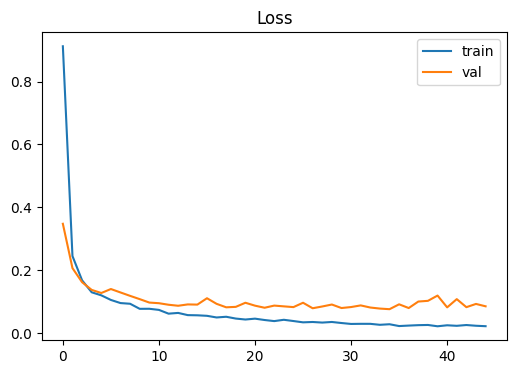

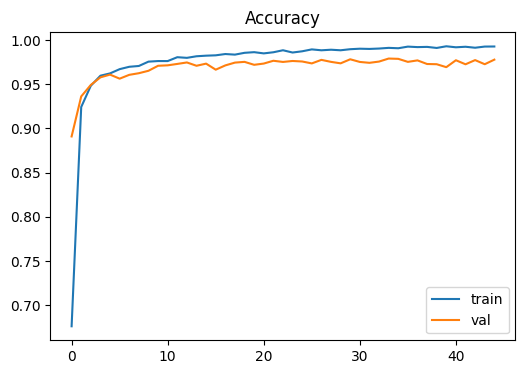

In [40]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

Testing: 40it [00:04,  9.27it/s]

Test accuracy: 0.9798
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



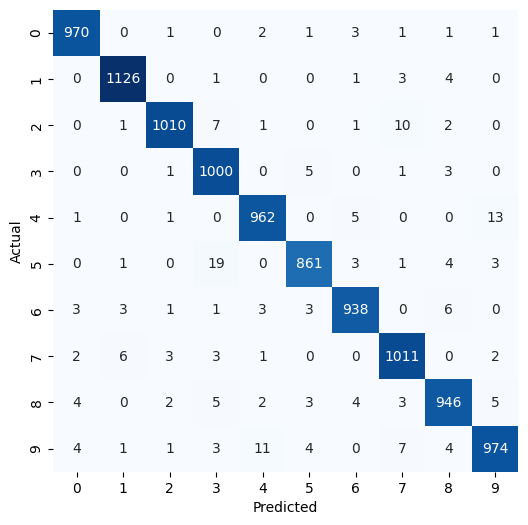

In [41]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(labels, preds))

# Print confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Basic ViT on CIFAR10

```
Using mps device
Loading CIFAR10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100 [Training]: 100%|██████████| 157/157 [01:03<00:00,  2.47it/s]
Epoch 1/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]
Epoch 1/100 - Train Loss: 2.0720, Train Acc: 0.2055, Val Loss: 1.9485, Val Acc: 0.2732
Epoch 2/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]
Epoch 2/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 2/100 - Train Loss: 1.9053, Train Acc: 0.2862, Val Loss: 1.8633, Val Acc: 0.3131
Epoch 3/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.95it/s]
Epoch 3/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 3/100 - Train Loss: 1.8012, Train Acc: 0.3326, Val Loss: 1.7921, Val Acc: 0.3351
Epoch 4/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]
Epoch 4/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 4/100 - Train Loss: 1.7301, Train Acc: 0.3612, Val Loss: 1.6873, Val Acc: 0.3746
Epoch 5/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]
Epoch 5/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 5/100 - Train Loss: 1.6707, Train Acc: 0.3852, Val Loss: 1.6393, Val Acc: 0.4068
Epoch 6/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]
Epoch 6/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 6/100 - Train Loss: 1.6340, Train Acc: 0.3983, Val Loss: 1.6151, Val Acc: 0.4040
Epoch 7/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]
Epoch 7/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 7/100 - Train Loss: 1.5878, Train Acc: 0.4212, Val Loss: 1.5575, Val Acc: 0.4276
Epoch 8/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 8/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 8/100 - Train Loss: 1.5618, Train Acc: 0.4298, Val Loss: 1.5776, Val Acc: 0.4192
Epoch 9/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 9/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 9/100 - Train Loss: 1.5241, Train Acc: 0.4450, Val Loss: 1.5223, Val Acc: 0.4482
Epoch 10/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 10/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 10/100 - Train Loss: 1.5136, Train Acc: 0.4480, Val Loss: 1.5038, Val Acc: 0.4614
Epoch 11/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 11/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 11/100 - Train Loss: 1.4945, Train Acc: 0.4582, Val Loss: 1.5013, Val Acc: 0.4641
Epoch 12/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 12/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 12/100 - Train Loss: 1.4717, Train Acc: 0.4663, Val Loss: 1.4629, Val Acc: 0.4692
Epoch 13/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 13/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 13/100 - Train Loss: 1.4497, Train Acc: 0.4745, Val Loss: 1.4712, Val Acc: 0.4677
Epoch 14/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 14/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 14/100 - Train Loss: 1.4357, Train Acc: 0.4805, Val Loss: 1.4193, Val Acc: 0.4866
Epoch 15/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 15/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 15/100 - Train Loss: 1.4254, Train Acc: 0.4835, Val Loss: 1.4407, Val Acc: 0.4825
Epoch 16/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 16/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 16/100 - Train Loss: 1.4208, Train Acc: 0.4887, Val Loss: 1.4372, Val Acc: 0.4874
Epoch 17/100 [Training]: 100%|██████████| 157/157 [00:56<00:00,  2.80it/s]
Epoch 17/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 17/100 - Train Loss: 1.3974, Train Acc: 0.4974, Val Loss: 1.4049, Val Acc: 0.4901
Epoch 18/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 18/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 18/100 - Train Loss: 1.3809, Train Acc: 0.5030, Val Loss: 1.4441, Val Acc: 0.4828
Epoch 19/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 19/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 19/100 - Train Loss: 1.3711, Train Acc: 0.5095, Val Loss: 1.3802, Val Acc: 0.5043
Epoch 20/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 20/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 20/100 - Train Loss: 1.3492, Train Acc: 0.5161, Val Loss: 1.3863, Val Acc: 0.5042
Epoch 21/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 21/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 21/100 - Train Loss: 1.3418, Train Acc: 0.5181, Val Loss: 1.3811, Val Acc: 0.4987
Epoch 22/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 22/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 22/100 - Train Loss: 1.3277, Train Acc: 0.5230, Val Loss: 1.3590, Val Acc: 0.5137
Epoch 23/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 23/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 23/100 - Train Loss: 1.3159, Train Acc: 0.5282, Val Loss: 1.3490, Val Acc: 0.5148
Epoch 24/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 24/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 24/100 - Train Loss: 1.3027, Train Acc: 0.5326, Val Loss: 1.3565, Val Acc: 0.5094
Epoch 25/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 25/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 25/100 - Train Loss: 1.2872, Train Acc: 0.5391, Val Loss: 1.3458, Val Acc: 0.5152
Epoch 26/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 26/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 26/100 - Train Loss: 1.2902, Train Acc: 0.5371, Val Loss: 1.3408, Val Acc: 0.5254
Epoch 27/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 27/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 27/100 - Train Loss: 1.2676, Train Acc: 0.5440, Val Loss: 1.3234, Val Acc: 0.5271
Epoch 28/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 28/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 28/100 - Train Loss: 1.2607, Train Acc: 0.5493, Val Loss: 1.3332, Val Acc: 0.5282
Epoch 29/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 29/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 29/100 - Train Loss: 1.2599, Train Acc: 0.5482, Val Loss: 1.3312, Val Acc: 0.5263
Epoch 30/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 30/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 30/100 - Train Loss: 1.2403, Train Acc: 0.5566, Val Loss: 1.3171, Val Acc: 0.5322
Epoch 31/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 31/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 31/100 - Train Loss: 1.2381, Train Acc: 0.5569, Val Loss: 1.2953, Val Acc: 0.5303
Epoch 32/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 32/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 32/100 - Train Loss: 1.2264, Train Acc: 0.5606, Val Loss: 1.2868, Val Acc: 0.5357
Epoch 33/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 33/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 33/100 - Train Loss: 1.2142, Train Acc: 0.5630, Val Loss: 1.2948, Val Acc: 0.5370
Epoch 34/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 34/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 34/100 - Train Loss: 1.2039, Train Acc: 0.5684, Val Loss: 1.2749, Val Acc: 0.5432
Epoch 35/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 35/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 35/100 - Train Loss: 1.1932, Train Acc: 0.5724, Val Loss: 1.2973, Val Acc: 0.5422
Epoch 36/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 36/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 36/100 - Train Loss: 1.1873, Train Acc: 0.5751, Val Loss: 1.2774, Val Acc: 0.5484
Epoch 37/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 37/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 37/100 - Train Loss: 1.1808, Train Acc: 0.5768, Val Loss: 1.2767, Val Acc: 0.5449
Epoch 38/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 38/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 38/100 - Train Loss: 1.1742, Train Acc: 0.5799, Val Loss: 1.2629, Val Acc: 0.5513
Epoch 39/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 39/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 39/100 - Train Loss: 1.1602, Train Acc: 0.5834, Val Loss: 1.2606, Val Acc: 0.5572
Epoch 40/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 40/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 40/100 - Train Loss: 1.1540, Train Acc: 0.5861, Val Loss: 1.2563, Val Acc: 0.5558
Epoch 41/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 41/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 41/100 - Train Loss: 1.1476, Train Acc: 0.5888, Val Loss: 1.2951, Val Acc: 0.5462
Epoch 42/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 42/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 42/100 - Train Loss: 1.1455, Train Acc: 0.5893, Val Loss: 1.2633, Val Acc: 0.5570
Epoch 43/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 43/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 43/100 - Train Loss: 1.1261, Train Acc: 0.5965, Val Loss: 1.2427, Val Acc: 0.5628
Epoch 44/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 44/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 44/100 - Train Loss: 1.1195, Train Acc: 0.5973, Val Loss: 1.2491, Val Acc: 0.5563
Epoch 45/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 45/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 45/100 - Train Loss: 1.1187, Train Acc: 0.5995, Val Loss: 1.2334, Val Acc: 0.5599
Epoch 46/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 46/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 46/100 - Train Loss: 1.1043, Train Acc: 0.6038, Val Loss: 1.2518, Val Acc: 0.5529
Epoch 47/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 47/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 47/100 - Train Loss: 1.0965, Train Acc: 0.6065, Val Loss: 1.2360, Val Acc: 0.5631
Epoch 48/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 48/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 48/100 - Train Loss: 1.0863, Train Acc: 0.6107, Val Loss: 1.2536, Val Acc: 0.5602
Epoch 49/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 49/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 49/100 - Train Loss: 1.0800, Train Acc: 0.6133, Val Loss: 1.2407, Val Acc: 0.5628
Epoch 50/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 50/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 50/100 - Train Loss: 1.0774, Train Acc: 0.6126, Val Loss: 1.2369, Val Acc: 0.5590
Epoch 51/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 51/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 51/100 - Train Loss: 1.0619, Train Acc: 0.6197, Val Loss: 1.2372, Val Acc: 0.5664
Epoch 52/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 52/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 52/100 - Train Loss: 1.0534, Train Acc: 0.6204, Val Loss: 1.2445, Val Acc: 0.5656
Epoch 53/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 53/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 53/100 - Train Loss: 1.0473, Train Acc: 0.6246, Val Loss: 1.2297, Val Acc: 0.5649
Epoch 54/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 54/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 54/100 - Train Loss: 1.0375, Train Acc: 0.6272, Val Loss: 1.2270, Val Acc: 0.5756
Epoch 55/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 55/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 55/100 - Train Loss: 1.0311, Train Acc: 0.6293, Val Loss: 1.2255, Val Acc: 0.5660
Epoch 56/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 56/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 56/100 - Train Loss: 1.0192, Train Acc: 0.6325, Val Loss: 1.2146, Val Acc: 0.5761
Epoch 57/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 57/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 57/100 - Train Loss: 1.0080, Train Acc: 0.6387, Val Loss: 1.2480, Val Acc: 0.5712
Epoch 58/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 58/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 58/100 - Train Loss: 1.0042, Train Acc: 0.6403, Val Loss: 1.2511, Val Acc: 0.5625
Epoch 59/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 59/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 59/100 - Train Loss: 0.9984, Train Acc: 0.6412, Val Loss: 1.2306, Val Acc: 0.5689
Epoch 60/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 60/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 60/100 - Train Loss: 0.9976, Train Acc: 0.6413, Val Loss: 1.2590, Val Acc: 0.5710
Epoch 61/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 61/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]
Epoch 61/100 - Train Loss: 0.9849, Train Acc: 0.6448, Val Loss: 1.2633, Val Acc: 0.5635
Epoch 62/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 62/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 62/100 - Train Loss: 0.9756, Train Acc: 0.6515, Val Loss: 1.2348, Val Acc: 0.5693
Epoch 63/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 63/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 63/100 - Train Loss: 0.9704, Train Acc: 0.6490, Val Loss: 1.2226, Val Acc: 0.5755
Epoch 64/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 64/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 64/100 - Train Loss: 0.9519, Train Acc: 0.6588, Val Loss: 1.2189, Val Acc: 0.5809
Epoch 65/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 65/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 65/100 - Train Loss: 0.9432, Train Acc: 0.6597, Val Loss: 1.2268, Val Acc: 0.5808
Epoch 66/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 66/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 66/100 - Train Loss: 0.9335, Train Acc: 0.6631, Val Loss: 1.2571, Val Acc: 0.5676
Epoch 67/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 67/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]
Epoch 67/100 - Train Loss: 0.9316, Train Acc: 0.6644, Val Loss: 1.2542, Val Acc: 0.5656
Epoch 68/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 68/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 68/100 - Train Loss: 0.9198, Train Acc: 0.6685, Val Loss: 1.2667, Val Acc: 0.5656
Epoch 69/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 69/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 69/100 - Train Loss: 0.9094, Train Acc: 0.6709, Val Loss: 1.2296, Val Acc: 0.5782
Epoch 70/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 70/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 70/100 - Train Loss: 0.9000, Train Acc: 0.6772, Val Loss: 1.2870, Val Acc: 0.5638
Epoch 71/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 71/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 71/100 - Train Loss: 0.8935, Train Acc: 0.6800, Val Loss: 1.2528, Val Acc: 0.5772
Epoch 72/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 72/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 72/100 - Train Loss: 0.8858, Train Acc: 0.6808, Val Loss: 1.2378, Val Acc: 0.5761
Epoch 73/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 73/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 73/100 - Train Loss: 0.8699, Train Acc: 0.6893, Val Loss: 1.2513, Val Acc: 0.5742
Epoch 74/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 74/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 74/100 - Train Loss: 0.8594, Train Acc: 0.6903, Val Loss: 1.2468, Val Acc: 0.5754
Epoch 75/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 75/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 75/100 - Train Loss: 0.8552, Train Acc: 0.6902, Val Loss: 1.2581, Val Acc: 0.5768
Epoch 76/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 76/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 76/100 - Train Loss: 0.8379, Train Acc: 0.7005, Val Loss: 1.2886, Val Acc: 0.5712
Early stopping due to no improvement in validation loss.
Total training time: 108.68 minutes
```

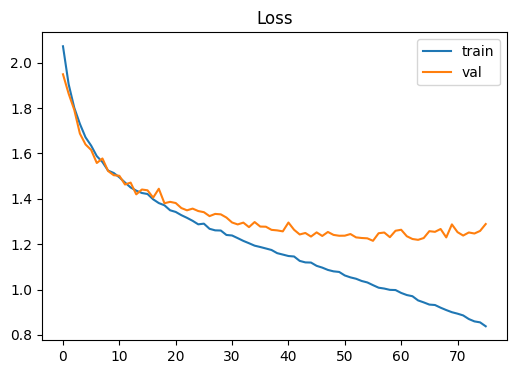

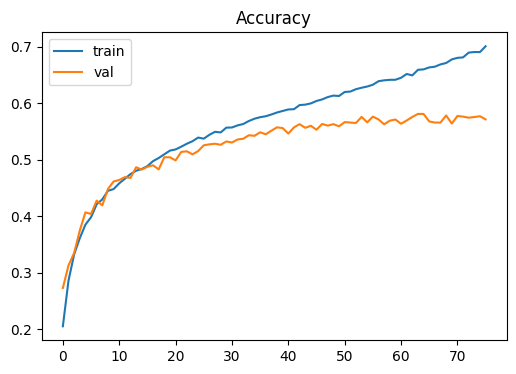

In [27]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

Testing: 40it [00:22,  1.75it/s]

Test accuracy: 0.5981
              precision    recall  f1-score   support

           0       0.58      0.73      0.65      1000
           1       0.73      0.67      0.70      1000
           2       0.49      0.48      0.49      1000
           3       0.45      0.39      0.42      1000
           4       0.54      0.51      0.52      1000
           5       0.51      0.49      0.50      1000
           6       0.65      0.67      0.66      1000
           7       0.70      0.65      0.67      1000
           8       0.71      0.73      0.72      1000
           9       0.61      0.67      0.64      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



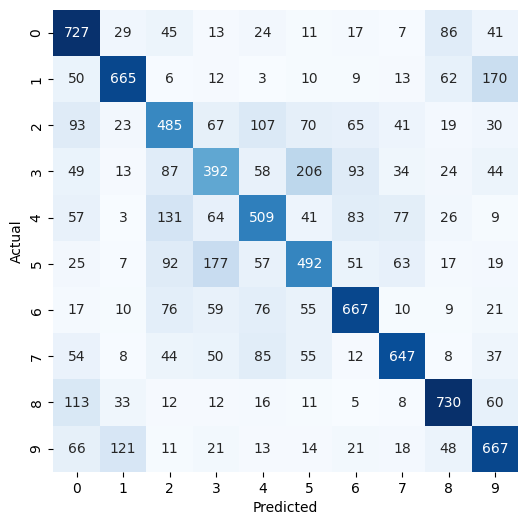

In [28]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(labels, preds))

# Print confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Basic ViT on CIFAR100

```
Using mps device
Loading CIFAR100 dataset...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 1/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 1/100 - Train Loss: 4.3066, Train Acc: 0.0400, Val Loss: 4.1651, Val Acc: 0.0550
Epoch 2/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.91it/s]
Epoch 2/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 2/100 - Train Loss: 4.0617, Train Acc: 0.0691, Val Loss: 4.0109, Val Acc: 0.0771
Epoch 3/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 3/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 3/100 - Train Loss: 3.8970, Train Acc: 0.0916, Val Loss: 3.8267, Val Acc: 0.1059
Epoch 4/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 4/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 4/100 - Train Loss: 3.7681, Train Acc: 0.1122, Val Loss: 3.7670, Val Acc: 0.1110
Epoch 5/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 5/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 5/100 - Train Loss: 3.6626, Train Acc: 0.1313, Val Loss: 3.6893, Val Acc: 0.1302
Epoch 6/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 6/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 6/100 - Train Loss: 3.5687, Train Acc: 0.1472, Val Loss: 3.5719, Val Acc: 0.1509
Epoch 7/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 7/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 7/100 - Train Loss: 3.4968, Train Acc: 0.1585, Val Loss: 3.4868, Val Acc: 0.1704
Epoch 8/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 8/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 8/100 - Train Loss: 3.4363, Train Acc: 0.1708, Val Loss: 3.4952, Val Acc: 0.1668
Epoch 9/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 9/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 9/100 - Train Loss: 3.3775, Train Acc: 0.1813, Val Loss: 3.4168, Val Acc: 0.1785
Epoch 10/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.88it/s]
Epoch 10/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 10/100 - Train Loss: 3.3281, Train Acc: 0.1908, Val Loss: 3.3996, Val Acc: 0.1848
Epoch 11/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.88it/s]
Epoch 11/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 11/100 - Train Loss: 3.2849, Train Acc: 0.1962, Val Loss: 3.3770, Val Acc: 0.1809
Epoch 12/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 12/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 12/100 - Train Loss: 3.2532, Train Acc: 0.2027, Val Loss: 3.3401, Val Acc: 0.1962
Epoch 13/100 [Training]: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
Epoch 13/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 13/100 - Train Loss: 3.2037, Train Acc: 0.2120, Val Loss: 3.3426, Val Acc: 0.1991
Epoch 14/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 14/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 14/100 - Train Loss: 3.1691, Train Acc: 0.2204, Val Loss: 3.2793, Val Acc: 0.2078
Epoch 15/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
Epoch 15/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 15/100 - Train Loss: 3.1283, Train Acc: 0.2228, Val Loss: 3.2804, Val Acc: 0.2062
Epoch 16/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 16/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 16/100 - Train Loss: 3.0913, Train Acc: 0.2341, Val Loss: 3.2561, Val Acc: 0.2141
Epoch 17/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]
Epoch 17/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 17/100 - Train Loss: 3.0638, Train Acc: 0.2387, Val Loss: 3.2376, Val Acc: 0.2176
Epoch 18/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 18/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 18/100 - Train Loss: 3.0175, Train Acc: 0.2446, Val Loss: 3.2164, Val Acc: 0.2229
Epoch 19/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 19/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 19/100 - Train Loss: 2.9876, Train Acc: 0.2505, Val Loss: 3.1836, Val Acc: 0.2268
Epoch 20/100 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 20/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 20/100 - Train Loss: 2.9491, Train Acc: 0.2590, Val Loss: 3.1986, Val Acc: 0.2268
Epoch 21/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.90it/s]
Epoch 21/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 21/100 - Train Loss: 2.9181, Train Acc: 0.2633, Val Loss: 3.1419, Val Acc: 0.2363
Epoch 22/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.89it/s]
Epoch 22/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 22/100 - Train Loss: 2.8918, Train Acc: 0.2667, Val Loss: 3.1506, Val Acc: 0.2397
Epoch 23/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 23/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 23/100 - Train Loss: 2.8617, Train Acc: 0.2745, Val Loss: 3.1424, Val Acc: 0.2402
Epoch 24/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 24/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 24/100 - Train Loss: 2.8275, Train Acc: 0.2816, Val Loss: 3.1321, Val Acc: 0.2411
Epoch 25/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 25/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 25/100 - Train Loss: 2.7959, Train Acc: 0.2873, Val Loss: 3.1430, Val Acc: 0.2421
Epoch 26/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 26/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 26/100 - Train Loss: 2.7639, Train Acc: 0.2909, Val Loss: 3.1083, Val Acc: 0.2471
Epoch 27/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 27/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 27/100 - Train Loss: 2.7266, Train Acc: 0.2991, Val Loss: 3.1118, Val Acc: 0.2481
Epoch 28/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 28/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 28/100 - Train Loss: 2.7057, Train Acc: 0.3009, Val Loss: 3.1046, Val Acc: 0.2477
Epoch 29/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 29/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 29/100 - Train Loss: 2.6720, Train Acc: 0.3088, Val Loss: 3.1086, Val Acc: 0.2568
Epoch 30/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 30/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 30/100 - Train Loss: 2.6480, Train Acc: 0.3167, Val Loss: 3.0999, Val Acc: 0.2547
Epoch 31/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 31/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 31/100 - Train Loss: 2.6019, Train Acc: 0.3226, Val Loss: 3.0817, Val Acc: 0.2506
Epoch 32/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 32/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 32/100 - Train Loss: 2.5787, Train Acc: 0.3272, Val Loss: 3.1024, Val Acc: 0.2579
Epoch 33/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 33/100 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 33/100 - Train Loss: 2.5489, Train Acc: 0.3311, Val Loss: 3.1058, Val Acc: 0.2609
Epoch 34/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 34/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 34/100 - Train Loss: 2.5174, Train Acc: 0.3396, Val Loss: 3.1310, Val Acc: 0.2586
Epoch 35/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 35/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]
Epoch 35/100 - Train Loss: 2.4843, Train Acc: 0.3453, Val Loss: 3.1473, Val Acc: 0.2597
Epoch 36/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 36/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]
Epoch 36/100 - Train Loss: 2.4523, Train Acc: 0.3559, Val Loss: 3.1107, Val Acc: 0.2596
Epoch 37/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 37/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 37/100 - Train Loss: 2.4110, Train Acc: 0.3623, Val Loss: 3.1118, Val Acc: 0.2621
Epoch 38/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
Epoch 38/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]
Epoch 38/100 - Train Loss: 2.3793, Train Acc: 0.3680, Val Loss: 3.1353, Val Acc: 0.2602
Epoch 39/100 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 39/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 39/100 - Train Loss: 2.3414, Train Acc: 0.3752, Val Loss: 3.1451, Val Acc: 0.2610
Epoch 40/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 40/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]
Epoch 40/100 - Train Loss: 2.3030, Train Acc: 0.3851, Val Loss: 3.1329, Val Acc: 0.2638
Epoch 41/100 [Training]: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]
Epoch 41/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]
Epoch 41/100 - Train Loss: 2.2707, Train Acc: 0.3891, Val Loss: 3.1586, Val Acc: 0.2610
Epoch 42/100 [Training]: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]
Epoch 42/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]
Epoch 42/100 - Train Loss: 2.2399, Train Acc: 0.3973, Val Loss: 3.1700, Val Acc: 0.2610
Epoch 43/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
Epoch 43/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]
Epoch 43/100 - Train Loss: 2.1954, Train Acc: 0.4057, Val Loss: 3.1819, Val Acc: 0.2591
Epoch 44/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 44/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]
Epoch 44/100 - Train Loss: 2.1508, Train Acc: 0.4156, Val Loss: 3.1827, Val Acc: 0.2638
Epoch 45/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
Epoch 45/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]
Epoch 45/100 - Train Loss: 2.1351, Train Acc: 0.4182, Val Loss: 3.2117, Val Acc: 0.2615
Epoch 46/100 [Training]: 100%|██████████| 157/157 [01:02<00:00,  2.50it/s]
Epoch 46/100 [Validation]: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]
Epoch 46/100 - Train Loss: 2.0878, Train Acc: 0.4284, Val Loss: 3.2313, Val Acc: 0.2673
Epoch 47/100 [Training]: 100%|██████████| 157/157 [00:56<00:00,  2.80it/s]
Epoch 47/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]
Epoch 47/100 - Train Loss: 2.0570, Train Acc: 0.4372, Val Loss: 3.2537, Val Acc: 0.2599
Epoch 48/100 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]
Epoch 48/100 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]
Epoch 48/100 - Train Loss: 2.0031, Train Acc: 0.4480, Val Loss: 3.2703, Val Acc: 0.2667
Epoch 49/100 [Training]: 100%|██████████| 157/157 [00:56<00:00,  2.78it/s]
Epoch 49/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]
Epoch 49/100 - Train Loss: 1.9689, Train Acc: 0.4555, Val Loss: 3.3196, Val Acc: 0.2584
Epoch 50/100 [Training]: 100%|██████████| 157/157 [00:59<00:00,  2.63it/s]
Epoch 50/100 [Validation]: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]
Epoch 50/100 - Train Loss: 1.9405, Train Acc: 0.4603, Val Loss: 3.2944, Val Acc: 0.2621
Epoch 51/100 [Training]: 100%|██████████| 157/157 [01:33<00:00,  1.68it/s]
Epoch 51/100 [Validation]: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]
Epoch 51/100 - Train Loss: 1.8857, Train Acc: 0.4743, Val Loss: 3.3111, Val Acc: 0.2718
Early stopping due to no improvement in validation loss.
Total training time: 74.23 minutes
```

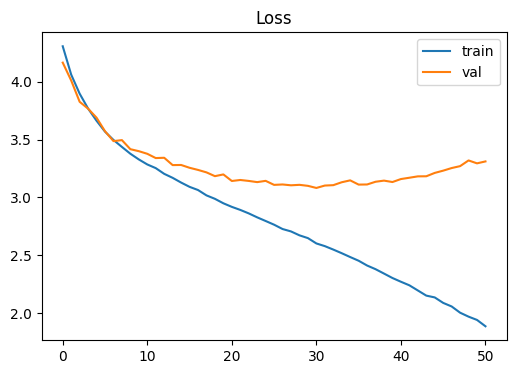

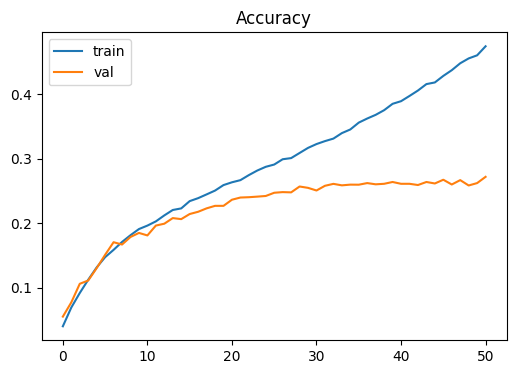

In [53]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [54]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(labels, preds))

# Print confusion matrix - can't print a confusion matrix because 100 classes :(
# cm = confusion_matrix(labels, preds)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Testing: 40it [00:23,  1.71it/s]

Test accuracy: 0.2836
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       100
           1       0.36      0.32      0.34       100
           2       0.13      0.07      0.09       100
           3       0.19      0.16      0.17       100
           4       0.18      0.11      0.14       100
           5       0.19      0.24      0.21       100
           6       0.20      0.38      0.26       100
           7       0.40      0.32      0.35       100
           8       0.19      0.27      0.22       100
           9       0.53      0.31      0.39       100
          10       0.30      0.07      0.11       100
          11       0.18      0.20      0.19       100
          12       0.26      0.31      0.29       100
          13       0.19      0.36      0.25       100
          14       0.21      0.16      0.18       100
          15       0.15      0.16      0.15       100
          16       0.31      0.28      0.29       100
     